Topic - BERTopic Modelling Only Financial Text

#### **1. Research Background**

- This study aims to apply the **BERTopic** model to financial texts (such as tweets) for topic modelling, and to explore the relationship between topics and market performance by combining sentiment analysis and market data.
    
- The goal is to test whether the sentiment of different topics can serve as trading signals and thereby build effective trading strategies.
    

---

#### **2. Data and Methodology**

##### **Data Sources**

1. **Financial Tweet Data**:
    
    - Includes tweet texts and their sentiment scores from 2019 to 2022.
        
    - After preprocessing (e.g., removing empty tweets and time filtering), valid data was retained.
        
2. **Market Data**:
    
    - Includes technical indicators of Nvidia (NVDA), such as opening price, closing price, and trading volume.
        
    - Contains the VIX index as a market volatility factor.
        

##### **Methodology**

1. **BERTopic Model**:
    
    - Uses `SentenceTransformer` to extract text embeddings.
        
    - Applies `HDBSCAN` clustering to generate topics.
        
    - Outputs the dominant daily topic and its sentiment score.
        
2. **Sentiment and Topic Analysis**:
    
    - Calculates the average sentiment score of each daily topic.
        
    - Classifies topics into sentiment categories based on a keyword lexicon (e.g., bullish and bearish vocabularies).
        
3. **Trading Strategy**:
    
    - Generates trading signals based on topic sentiment:
        
        - Sentiment score > 0.02: Buy signal.
            
        - Sentiment score < -0.02: Sell signal.
            
    - Compares the performance of topic-based strategies with the market benchmark (Buy & Hold).

## BERTopic modeling

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import warnings
import os
from tqdm import tqdm
from hdbscan import HDBSCAN
warnings.filterwarnings('ignore')

SAMPLE!!!-->too much data for CPU to handle with in HDBSCAN step...almost 1GB and 500000+ data!

In [18]:
import os
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic

# avoid warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# read data
df = pd.read_csv("../2_data/financial_tweets_with_sentiment.csv", parse_dates=["Date"])
df = df.dropna(subset=['Processed_Tweet'])  
df = df[(df["Date"] >= "2019-01-01") & (df["Date"] <= "2022-12-31")].copy()
df["YearMonth"] = df["Date"].dt.to_period("M")

texts = df["Processed_Tweet"].astype(str).tolist()

texts = df["Processed_Tweet"].astype(str).tolist()
texts = list(tqdm(texts, desc="Preparing texts"))

# Step 2: Load embedded model IF YOU DON'T HAVE GPU, DROP 'DEVICE=CUDA'
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Step 3: Define BERTopic 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean')
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=False, # initially not produce prob (too slow)
    verbose=True,
    nr_topics = 30
)

# Step 4: model training
topics, _ = topic_model.fit_transform(texts)
df["topic"] = topics

# check the number of topics
n_noise = (df["topic"] == -1).sum()
print(f"❗ Number of tweets that could not be categorized: {n_noise} ({n_noise / len(df):.2%})")

# filter out noise
df = df[df["topic"] != -1].reset_index(drop=True)

# store the topic model
df.to_csv("../2_data/with_BERTtopics.csv", index=False)


Preparing texts: 100%|██████████| 40557/40557 [00:00<00:00, 12802618.15it/s]
2025-05-23 11:18:22,824 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1268 [00:00<?, ?it/s]

2025-05-23 11:18:52,287 - BERTopic - Embedding - Completed ✓
2025-05-23 11:18:52,288 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-23 11:19:00,601 - BERTopic - Dimensionality - Completed ✓
2025-05-23 11:19:00,602 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 11:19:03,048 - BERTopic - Cluster - Completed ✓
2025-05-23 11:19:03,049 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-23 11:19:03,328 - BERTopic - Representation - Completed ✓
2025-05-23 11:19:03,329 - BERTopic - Topic reduction - Reducing number of topics
2025-05-23 11:19:03,344 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 11:19:03,503 - BERTopic - Representation - Completed ✓
2025-05-23 11:19:03,505 - BERTopic - Topic reduction - Reduced number of topics from 400 to 30


❗ Number of tweets that could not be categorized: 18170 (44.80%)


In [19]:
# Step 6: Results Evaluation
import matplotlib.pyplot as plt


# 1. check the topic overview
print(topic_model.get_topic_info().head(10))     # top 10 topic 
print(topic_model.get_topic(0))                  # check topic 0
# 2. check the topic distribution
fig_hierarchy = topic_model.visualize_hierarchy()
fig_hierarchy.show()

# 3. Visualize topic distribution 
fig_barchart = topic_model.visualize_barchart(top_n_topics=10)
fig_barchart.show()

fig_topics = topic_model.visualize_topics()
fig_topics.show()


topic_counts = df["topic"].value_counts()
print(topic_counts.head(10))

# 4. Visualize topics over time
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df_clean = df.dropna(subset=["Date", "Processed_Tweet", "topic"])
docs = df_clean["Processed_Tweet"].tolist()
timestamps = df_clean["Date"].tolist()
topics = df_clean["topic"].tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps, topics=topics)
fig = topic_model.visualize_topics_over_time(topics_over_time)
fig.show()

# 5. print top 5 topics
print("\nTop 5 Topics:")
for topic_num in range(5):
    print(f"\nTopic {topic_num}:")
    print(topic_model.get_topic(topic_num))


# 6. print top 5 topics with their keywords
topic_keywords = {}
for topic_num in df["topic"].unique():
    words = topic_model.get_topic(topic_num)
    keywords = [word for word, _ in words[:10]]
    topic_keywords[topic_num] = keywords

# 7. Manual setup of bullish / bearish keyword library (extensible)
bullish_words = {"growth", "beat", "record", "strong", "buy", "profit", "boom", "innovation", "optimism"}
bearish_words = {"loss", "fear", "fall", "crash", "bad", "bear", "cut", "warning", "down", "panic"}

# Determine the number of positive/negative sentiment words in each topic keyword
bullish_topics = []
bearish_topics = []

for topic_num, keywords in topic_keywords.items():
    score = sum(kw in bullish_words for kw in keywords) - sum(kw in bearish_words for kw in keywords)
    if score >= 1:
        bullish_topics.append(topic_num)
    elif score <= -1:
        bearish_topics.append(topic_num)

print("🐂 Bullish Topics:", bullish_topics)
print("🐻 Bearish Topics:", bearish_topics)




   Topic  Count                             Name  \
0     -1  18170          -1_nvda_stock_share_buy   
1      0  12882         0_stock_nvda_share_trade   
2      1   3232      1_bullish_bear_nvda_bearish   
3      2   1856       2_volum_upgrad_nvda_rocket   
4      3   1274      3_elliottwav_updat_box_blue   
5      4    721     4_target_price_rais_maintain   
6      5    433   5_star_watchlist_watch_freedom   
7      6    402     6_trade_alert_twitter_follow   
8      7    338  7_sentiment_paid_strike_premium   
9      8    294      8_return_valuat_sampp_total   

                                      Representation  \
0  [nvda, stock, share, buy, market, amd, go, pri...   
1  [stock, nvda, share, trade, amd, last, market,...   
2  [bullish, bear, nvda, bearish, green, bull, ga...   
3  [volum, upgrad, nvda, rocket, downgrad, low, c...   
4  [elliottwav, updat, box, blue, view, area, tra...   
5  [target, price, rais, maintain, nvidia, analys...   
6  [star, watchlist, watch, freedom

2025-05-23 11:19:03,984 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 1109) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 


topic
0    12882
1     3232
2     1856
3     1274
4      721
5      433
6      402
7      338
8      294
9      188
Name: count, dtype: int64


1109it [00:14, 76.41it/s]



Top 5 Topics:

Topic 0:
[('stock', np.float64(0.025094910502785277)), ('nvda', np.float64(0.024902538263754704)), ('share', np.float64(0.02109827605085813)), ('trade', np.float64(0.01734469547849554)), ('amd', np.float64(0.01484120696289843)), ('last', np.float64(0.014702258375354185)), ('market', np.float64(0.014407425668755941)), ('buy', np.float64(0.013337978281001858)), ('min', np.float64(0.012826298839282341)), ('split', np.float64(0.012352727503697935))]

Topic 1:
[('bullish', np.float64(0.08728442448180808)), ('bear', np.float64(0.046259488444316973)), ('nvda', np.float64(0.03980970406957191)), ('bearish', np.float64(0.03795203597763277)), ('green', np.float64(0.03439655005665018)), ('bull', np.float64(0.030690972656618923)), ('gap', np.float64(0.022435890238356997)), ('flow', np.float64(0.01783404449152063)), ('today', np.float64(0.017291399834881746)), ('day', np.float64(0.015455840813359961))]

Topic 2:
[('volum', np.float64(0.14172193792087065)), ('upgrad', np.float64(0.094

# Trading Strategy

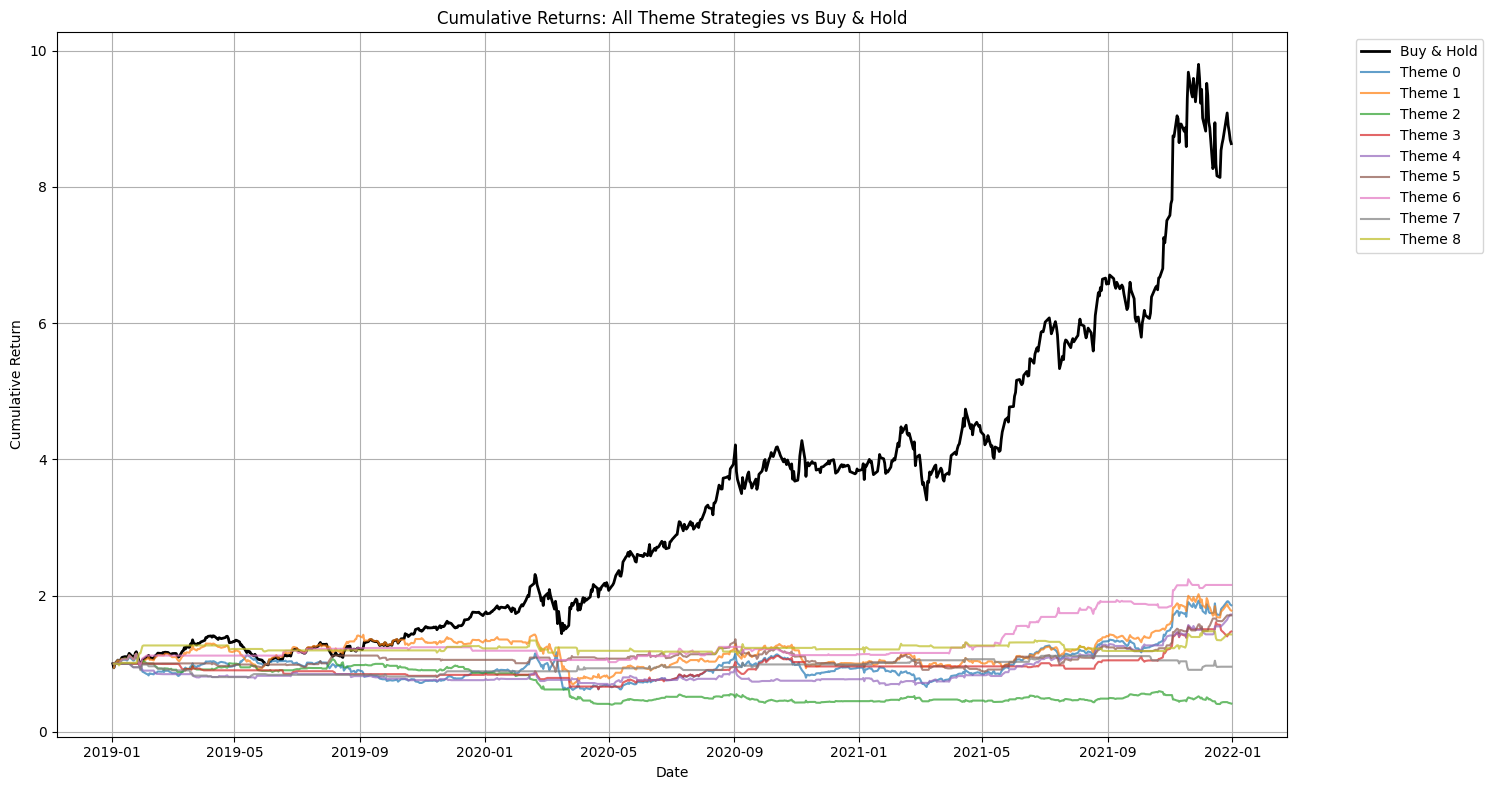


Final Returns by Thematic Strategy:
Theme 0: 85.81%
Theme 1: 78.03%
Theme 2: -58.55%
Theme 3: 47.26%
Theme 4: 72.20%
Theme 5: 70.98%
Theme 6: 115.62%
Theme 7: -4.44%
Buy & Hold: 763.63%


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. read sentiment data
df['Date'] = pd.to_datetime(df['Date'])
daily_theme_sentiment = df.groupby(['Date', 'topic'])['sentiment_score'].mean().unstack()

# 2. read price data
price_df = pd.read_csv('../2_data/sentiment_price_vix_inner_aligned.csv')
price_df['Date'] = pd.to_datetime(price_df['index'])
price_df = price_df.set_index('Date')

# 3. calculate daily returns
plt.figure(figsize=(15, 8))

# draw buy & hold strategy
returns = price_df['nvda_close'].pct_change().fillna(0)
cum_returns = (1 + returns).cumprod()
plt.plot(cum_returns.index, cum_returns, label='Buy & Hold', color='black', linewidth=2)

# calculate daily returns for each theme
for theme in range(9):  
    # generate signals based on sentiment
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    
    # align the signals with price data
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    
    # calculate strategy returns
    strategy_returns = strategy_data['position'].shift(1) * returns
    cum_strategy_returns = (1 + strategy_returns).cumprod()
    
    # plot cumulative returns
    plt.plot(cum_strategy_returns.index, cum_strategy_returns, label=f'Theme {theme}', alpha=0.7)

plt.title('Cumulative Returns: All Theme Strategies vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# pirnt final returns
print("\nFinal Returns by Thematic Strategy:")
for theme in range(8):
    signal = daily_theme_sentiment[theme].rolling(3, min_periods=1).mean()
    position = (signal > 0.02).astype(int) - (signal < -0.02).astype(int)
    strategy_data = pd.DataFrame({'position': position})
    strategy_data = pd.merge(
        strategy_data,
        price_df[['nvda_close']],
        left_index=True,
        right_index=True,
        how='inner'
    )
    strategy_returns = strategy_data['position'].shift(1) * returns
    final_return = (1 + strategy_returns).prod() - 1
    print(f"Theme {theme}: {final_return:.2%}")
print(f"Buy & Hold: {cum_returns[-1]-1:.2%}")

In [21]:
import pandas as pd

# read data
df = pd.read_csv("../2_data/with_BERTtopics.csv", parse_dates=["Date"])

# only keep topics 0, 1, and 2
df_filtered = df[df["topic"].isin([0, 1, 2])]

# Calculate the average sentiment score, number of tweets, and standard deviation of sentiment for each topic on a daily basis, grouped by date and topic
daily_stats = (
    df_filtered.groupby(["Date", "topic"])["sentiment_score"]
    .agg(['mean', 'count', 'std'])
    .reset_index()
    .pivot(index="Date", columns="topic")
)

# Rename columns for clarity
daily_stats.columns = [
    f"topic_{col[1]}_{col[0]}"
    for col in daily_stats.columns
]

# check results
print(daily_stats.head())

daily_stats.to_csv("../2_data/daily_topic012_sentiment_stats.csv")

            topic_0_mean  topic_1_mean  topic_2_mean  topic_0_count  \
Date                                                                  
2019-01-01      1.000000           NaN           NaN            1.0   
2019-01-02      0.500000      0.500000           0.0            2.0   
2019-01-03      0.090909      0.000000           NaN           11.0   
2019-01-04     -0.166667      0.333333           NaN            6.0   
2019-01-05      0.000000           NaN           NaN            1.0   

            topic_1_count  topic_2_count  topic_0_std  topic_1_std  \
Date                                                                 
2019-01-01            NaN            NaN          NaN          NaN   
2019-01-02            2.0            1.0     0.707107     0.707107   
2019-01-03            3.0            NaN     0.301511     1.000000   
2019-01-04            3.0            NaN     0.408248     0.577350   
2019-01-05            NaN            NaN          NaN          NaN   

           

In [22]:
import pandas as pd

df = pd.read_csv("../2_data/with_BERTtopics.csv", parse_dates=["Date"])

# only keep topic 0
df_filtered = df[df["topic"].isin([0])]

# Calculate the average sentiment score, number of tweets, and standard deviation of sentiment for each topic on a daily basis, grouped by date and topic
daily_stats = (
    df_filtered.groupby(["Date", "topic"])["sentiment_score"]
    .agg(['mean', 'count', 'std'])
    .reset_index()
    .pivot(index="Date", columns="topic")
)

# rename columns for clarity
daily_stats.columns = [
    f"topic_{col[1]}_avg_sentiment_score" if col[0] == 'mean' else
    f"topic_{col[1]}_tweet_count" if col[0] == 'count' else
    f"topic_{col[1]}_sentiment_std"
    for col in daily_stats.columns
]

# Reset index, rename Date column to date
daily_stats = daily_stats.reset_index().rename(columns={"Date": "date"})

# check results
print(daily_stats.head())

daily_stats.to_csv("../2_data/daily_topic0_sentiment_stats.csv", index=False)

        date  topic_0_avg_sentiment_score  topic_0_tweet_count  \
0 2019-01-01                     1.000000                    1   
1 2019-01-02                     0.500000                    2   
2 2019-01-03                     0.090909                   11   
3 2019-01-04                    -0.166667                    6   
4 2019-01-05                     0.000000                    1   

   topic_0_sentiment_std  
0                    NaN  
1               0.707107  
2               0.301511  
3               0.408248  
4                    NaN  


Exception ignored in: <function ResourceTracker.__del__ at 0x106e851c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10675d1c0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/m

In [ ]:
df = pd.read_csv("../2_data/tweet_level_sentiment.csv")
texts = df['Processed_Tweet'].astype(str).tolist()


embeddings = embedding_model.encode(texts, show_progress_bar=True)
print(embeddings.shape) 

Batches:   0%|          | 0/8334 [00:00<?, ?it/s]

(266660, 384)


In [25]:
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=3, metric="euclidean")

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
import pandas as pd
from tqdm import tqdm

# Load data


# Preprocessing: Remove stop words and tokenize (optional, as BERTopic handles this internally)
# You can add custom preprocessing here if needed.

# Step 1: Load SentenceTransformer model for embeddings
embedding_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

# Step 2: Define BERTopic with custom vectorizer and HDBSCAN


vectorizer_model = CountVectorizer(stop_words="english", max_df=0.95, min_df=2)
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=3, metric="euclidean")  

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=False,  
    verbose=True
)

# Step 3: Fit BERTopic model
print("Fitting BERTopic model...")
try:
    topics, probs = topic_model.fit_transform(texts)
    df["topic"] = topics
except AttributeError as e:
    print(f"Error during BERTopic fitting: {e}")
    print("Trying again with adjusted parameters...")
    # 尝试禁用 UMAP 或进一步调整参数
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        hdbscan_model=hdbscan_model,
        umap_model=None,  # 禁用 UMAP
        calculate_probabilities=False,
        verbose=True
    )
    topics = topic_model.fit_transform(texts)
    df["topic"] = topics

# Add topics to the DataFrame
df["topic"] = topics

# Step 4: Print top keywords for each topic
print("Top keywords for each topic:")
for topic_num in range(len(topic_model.get_topics())):
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}")

# Step 5: Save results
df.to_csv("../2_data/tweets_withGibbs-BERTopic_topics.csv", index=False)

# Step 6: Visualize topics
print("Visualizing topics...")
topic_model.visualize_barchart(top_n_topics=10).show()
topic_model.visualize_topics().show()
topic_model.visualize_hierarchy().show()

# Step 7: Optional - Gibbs-like sampling for topic probabilities
# If you want to simulate Gibbs sampling, you can use the `probs` output
# to sample topics based on their probabilities.
import numpy as np

def gibbs_sampling(probs, num_samples=10):
    sampled_topics = []
    for prob in probs:
        sampled_topics.append(np.random.choice(len(prob), p=prob))
    return sampled_topics

sampled_topics = gibbs_sampling(probs)
df["sampled_topic"] = sampled_topics

# Save sampled topics
df.to_csv("../2_data/tweets_withGibbs-BERTopic.csv", index=False)

print("Gibbs sampling completed and results saved.")

2025-05-23 13:18:43,656 - BERTopic - Embedding - Transforming documents to embeddings.


Fitting BERTopic model...


Batches:   0%|          | 0/8334 [00:00<?, ?it/s]

2025-05-23 13:21:17,992 - BERTopic - Embedding - Completed ✓
2025-05-23 13:21:17,992 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-23 13:24:19,307 - BERTopic - Dimensionality - Completed ✓
2025-05-23 13:24:19,312 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 13:24:25,438 - BERTopic - Cluster - Completed ✓
2025-05-23 13:24:25,471 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 13:24:27,444 - BERTopic - Representation - Completed ✓


Top keywords for each topic:
Topic 0: [('masterpiec', np.float64(0.04340511111722207)), ('pleaseee', np.float64(0.04058916866773097)), ('mission', np.float64(0.03530121998159372)), ('pl', np.float64(0.03078861299179039)), ('est', np.float64(0.029951197445419082)), ('infuri', np.float64(0.028936740744814712)), ('disgrac', np.float64(0.02889457844269233)), ('manifest', np.float64(0.027929832152180978)), ('accomplish', np.float64(0.02647591498619529)), ('comin', np.float64(0.026215801287568792))]
Topic 1: [('profit', np.float64(0.011156812853474692)), ('taker', np.float64(0.004565810999775615)), ('took', np.float64(0.003945771347454221)), ('reenter', np.float64(0.0018297940209411538)), ('taken', np.float64(0.0016656532423892287)), ('rkt', np.float64(0.0014874476786894257)), ('greedi', np.float64(0.0013380206707506025)), ('tabl', np.float64(0.0012155005721899879)), ('trim', np.float64(0.0011158471141157495)), ('book', np.float64(0.0010922296824574143))]
Topic 2: [('basement', np.float64(0.